## Packages

In [42]:
# packages for basic python calculation
import pandas as pd
import numpy as np

# packages for plots
import matplotlib.pyplot as plt

# warning ignore
import warnings
warnings.filterwarnings("ignore")

# packages for statistics
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# packages for fft
import spectrum
from spectrum import Periodogram, data_cosine

# packages for ML
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# others
import random
import time

## Data Import

In [43]:
file_path = 'data/buy/acad1Buy3ML10years.txt'

df = pd.read_csv(file_path, delimiter= '\s+', header = None)
osc = df.iloc[0:,0:41]
stk = df.iloc[0:, 41:82]
macd = df.iloc[0:, 82:123]
rtn = df.iloc[0:,123]
label = np.sign(rtn)
label = label.map({1: 1, -1: 0, 0:0})
results = label.map({1: 'EARN', 0: 'LOSS'})

## EDA

In [44]:
def EDA(index, osc_ind = True, stk_ind = True, macd_ind = True, style = 'bmh', figsize=(7,7)):
    
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        num_layout = np.sum([osc_ind, stk_ind, macd_ind])
        layout = (num_layout, 1)

        if osc_ind:
            osc_ax = plt.subplot2grid(layout, (0, 0))
            osc_ax.plot(range(41), osc.iloc[index,:])
            osc_ax.invert_xaxis()
            osc_ax.set_title('Oscillator 3-Day Time Series')
            osc_ax.set_xlabel('Time')
            osc_ax.set_ylabel('Oscillator')
        
        if stk_ind:
            stk_ax = plt.subplot2grid(layout, (1, 0))
            stk_ax.plot(range(41), stk.iloc[index,:])
            stk_ax.invert_xaxis()
            stk_ax.set_title('Stock Price 3-Day Time Series')
            stk_ax.set_xlabel('Time')
            stk_ax.set_ylabel('Stock Price')
        
        if macd_ind:
            macd_ax = plt.subplot2grid(layout, (2, 0))
            macd_ax.plot(range(41), macd.iloc[index,:])
            macd_ax.invert_xaxis()
            macd_ax.set_title('MACD 3-Day Time Series')
            macd_ax.set_xlabel('Time')
            macd_ax.set_ylabel('MACD')
        
        
        plt.tight_layout()

LOSS, -0.59


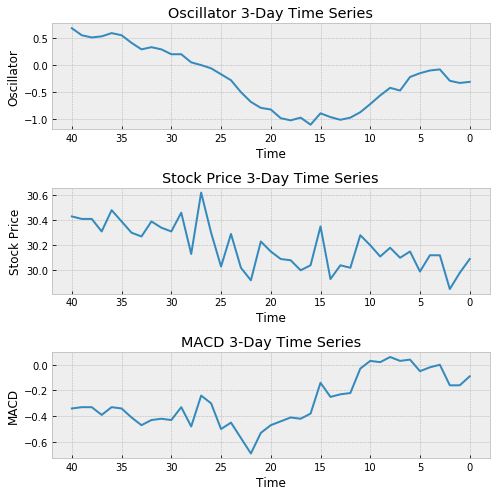

In [23]:
# Plot basic EDA
index = random.randint(0,len(df))
EDA(index)
if label[index] == 1:
    TCOL =  '\033[1;32m' # Green Text 
else:
    TCOL = '\033[1;31m' # Red Text
print (TCOL + results[index] + ", " + str(rtn[index]))

## Time Series Analysis

In [45]:
def tsplot(y, lags=None, figsize=(10, 5), style='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.invert_xaxis()
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()


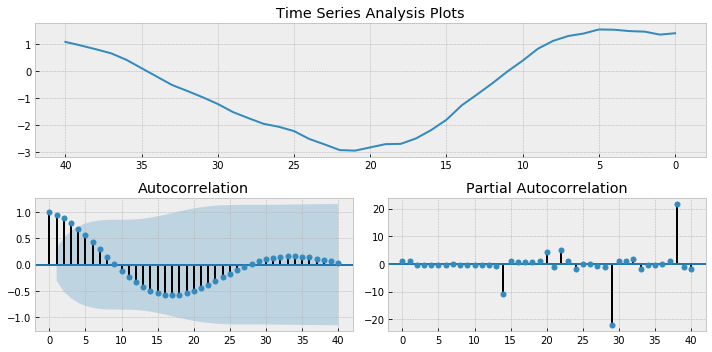

In [46]:
tsplot(osc.iloc[index,:], lags=40)

## Smoothing

In [47]:
def smoothTriangle(data, degree, dropVals=False):
    triangle=np.array(list(range(degree)) + [degree] + list(range(degree)[::-1])) + 1
    smoothed=[]

    for i in range(degree, len(data) - degree * 2):
        point=data[i:i + len(triangle)] * triangle
        smoothed.append(sum(point)/sum(triangle))
    if dropVals:
        return smoothed
    smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
    while len(smoothed) < len(data):
        smoothed.append(smoothed[-1])
    return smoothed

In [48]:
def smoothEDA(index, plt_df = osc, ylabel = 'Oscillator', style = 'bmh', figsize=(6,3)):
    
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (1, 1)
        
        ax = plt.subplot2grid(layout, (0, 0))
        data = plt_df.iloc[index,:]
        ax.plot(range(41), data, '.-', label='original OSC')
        ax.plot(range(41), smoothTriangle(data, 3), '-', label='smoothed OSC')
        #ax.plot(range(41), smoothTriangle(data, 5), '-', label='smoothed OSC d=5')
        #ax.set_title('Moving Triangle Smoothing')
        ax.set_xlabel('Time')
        ax.set_ylabel(ylabel)
        plt.legend()
        
        
        plt.tight_layout()

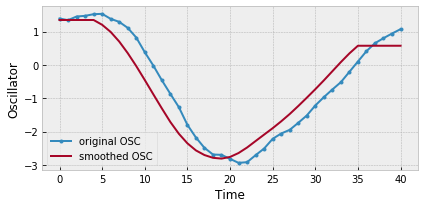

In [49]:
smoothEDA(index)

## PSD Calculation

In [50]:
def psd_generator(data, NFFT = 100, name = "osc"):
    freq = []
    for i in range(data.shape[0]):
        data_osc = data.iloc[i,:]
        p = Periodogram(data_osc, NFFT=NFFT)
        temp_list = list(p.psd)
        freq.append(temp_list)
     
    col_name = []
    for i in range(int(NFFT/2)+1):
        col_name.append("freq"+str(i))
    
    psd_df = pd.DataFrame(freq, columns=col_name) 
    return psd_df

In [51]:
psd_generator(osc).head()

,freq0,freq1,freq2,freq3,freq4,freq5,freq6,freq7,freq8,freq9,...,freq41,freq42,freq43,freq44,freq45,freq46,freq47,freq48,freq49,freq50
0,0.0676,0.0667,0.0639,0.0594,0.0537,0.0470,0.0398,0.0326,0.0258,0.0196,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,1.8627,4.5057,10.1725,13.9766,12.7731,7.9040,3.1527,0.6931,0.0476,0.0026,...,0.0021,0.0031,0.0034,0.0029,0.0021,0.0013,0.0007,0.0003,0.0001,0.0000
2,0.4324,1.1047,3.2339,6.0782,7.4156,5.8600,2.8223,0.6713,0.0253,0.0254,...,0.0032,0.0044,0.0046,0.0037,0.0025,0.0014,0.0008,0.0003,0.0001,0.0000
3,0.0232,0.5882,2.3849,4.8252,6.1256,5.1308,2.8030,0.9256,0.1568,0.0317,...,0.0023,0.0027,0.0025,0.0018,0.0010,0.0005,0.0003,0.0003,0.0002,0.0002
4,0.1167,0.5425,1.9871,4.0183,5.0898,4.2682,2.4248,0.9514,0.2799,0.0795,...,0.0010,0.0009,0.0007,0.0005,0.0003,0.0001,0.0000,0.0001,0.0002,0.0003


## MACD

In [52]:
def derivative(data, space = 1, name = "macd"):
    dy = []
    for i in range(data.shape[0]):
        y = pd.Series(data.iloc[i,:])
        temp_dy = list(np.gradient(y, space))
        dy.append(temp_dy)
    
    col_name = []
    for i in range(data.shape[1]):
        col_name.append(name + "deriv"+ str(i))
        
    deriv_df = pd.DataFrame(dy, columns=col_name) 
    
    return deriv_df

In [53]:
derivative(macd).head()

,macdderiv0,macdderiv1,macdderiv2,macdderiv3,macdderiv4,macdderiv5,macdderiv6,macdderiv7,macdderiv8,macdderiv9,...,macdderiv31,macdderiv32,macdderiv33,macdderiv34,macdderiv35,macdderiv36,macdderiv37,macdderiv38,macdderiv39,macdderiv40
0,-0.0100,-0.0100,-0.0100,-0.0100,-0.0050,0.0000,0.0000,0.0050,0.0100,0.0050,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,-0.0400,-0.0200,-0.0050,-0.0100,-0.0050,-0.0050,-0.0050,0.0050,0.0000,0.0000,...,-0.0100,-0.0050,0.0000,0.0000,0.0050,0.0100,0.0050,0.0000,0.0000,0.0000
2,0.0000,0.0000,-0.0050,0.0000,0.0000,-0.0100,0.0000,0.0100,0.0000,-0.0100,...,0.0050,0.0000,0.0000,0.0050,0.0000,-0.0050,-0.0050,-0.0050,-0.0100,-0.0100
3,0.0000,0.0000,0.0050,0.0000,-0.0100,-0.0100,-0.0050,0.0000,-0.0050,0.0000,...,-0.0050,-0.0050,-0.0050,-0.0050,0.0000,0.0000,0.0050,0.0000,0.0000,0.0100
4,0.0000,0.0050,0.0050,0.0000,0.0050,0.0200,0.0150,0.0000,0.0050,0.0000,...,0.0000,0.0100,0.0150,0.0250,0.0350,0.0200,-0.0050,-0.0050,-0.0050,-0.0100


## Modeling Phase

In [54]:
classifiers = {
    #'knn'           : KNeighborsClassifier(),
    'Random Forest' : RandomForestClassifier(n_estimators=50),
    #'naive bayes': MultinomialNB(),
    #'decision tree' : DecisionTreeClassifier(),
    'Logistic Regression'  : LogisticRegression(multi_class="multinomial", solver="lbfgs"),
    'SVM' : SVC(C=100, gamma="scale")
}

In [55]:
def precision_pipline(model, feature_matrix, test_size = 0.2):    
   #Split test set
    X, X_test, y, y_test = train_test_split(feature_matrix, label, test_size=test_size)

    #Split train/validation set
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size)
    
    model.fit(X_train, y_train)
    
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)

    
    pred = model.predict(X_test)
    true = y_test
    df_ana = pd.DataFrame({"pred":pred,
                          "true":true})
    test_precision = sum(df_ana['true'] & df_ana['pred'])/sum(df_ana['pred'])

    return train_acc, test_acc, test_precision

In [35]:
def model_fitting_pipline(feature_matrix, running_time=20):
    train_scores = dict()
    test_scores = dict()
    test_precisions = dict()
    training_times = dict()

    for classifier_name, classifier_obj in classifiers.items():
        print("Fitting", classifier_name)
        m_train_acc = []
        m_test_acc = []
        m_test_precision = []
        m_train_time = []
        for i in range(running_time):
            t = time.time()
            train_acc, test_acc, test_precision = precision_pipline(classifier_obj, feature_matrix)
            
            m_train_acc.append(train_acc)
            m_test_acc.append(test_acc)
            m_test_precision.append(test_precision)
            m_train_time.append(time.time() - t)

        training_times[classifier_name] = np.mean(m_train_time)
        train_scores[classifier_name] = np.mean(m_train_acc)
        test_scores[classifier_name] = np.mean(m_test_acc)
        test_precisions[classifier_name] = np.mean(m_test_precision)

    pd.options.display.float_format = '{:,.4f}'.format
    data = {"Train Accuracy": train_scores, 
            "Test Accuracy" : test_scores, 
            "Test Precision": test_precisions, 
            "Training Time(s)" : training_times}
    result_df = pd.DataFrame(data, columns=data.keys())
    result_df.index = list(classifiers.keys())
    return result_df

### Model 0 - Baseline Model

#### Model 0a - OSC Only

In [56]:
bm_matrix = osc
model_fitting_pipline(bm_matrix)

Fitting Random Forest
Fitting Logistic Regression
Fitting SVM


,Train Accuracy,Test Accuracy,Test Precision,Training Time(s)
Random Forest,0.6509,0.6477,0.3168,0.0530
Logistic Regression,0.9998,0.6189,0.3965,0.4480
SVM,0.8265,0.6009,0.3494,0.8547


#### Model 0b - Everything Included

In [57]:
bm2_matrix = pd.concat([osc, stk, macd], axis=1)
model_fitting_pipline(bm2_matrix)

Fitting Random Forest
Fitting Logistic Regression
Fitting SVM


,Train Accuracy,Test Accuracy,Test Precision,Training Time(s)
Random Forest,0.6562,0.6437,0.4148,0.0823
Logistic Regression,0.9997,0.6162,0.3984,0.6800
SVM,0.8134,0.6130,0.4078,1.4777


### Model 1 - Adding PSD

In [59]:
psd_osc = psd_generator(osc, NFFT = 100)
m1_matrix = pd.concat([osc, psd_osc], axis=1)
model_fitting_pipline(m1_matrix)

Fitting Random Forest
Fitting Logistic Regression
Fitting SVM


,Train Accuracy,Test Accuracy,Test Precision,Training Time(s)
Random Forest,0.6511,0.6416,0.5152,0.0789
Logistic Regression,0.9999,0.6239,0.3963,0.6346
SVM,0.6795,0.6360,0.3444,1.1922


### Model 2 - Adding MACD 1st/2nd Derivatives

In [60]:
deriv_macd_1 = derivative(macd)
deriv_macd_2 = derivative(deriv_macd_1)
m2_matrix = pd.concat([osc, deriv_macd_1, deriv_macd_2], axis=1)
model_fitting_pipline(m2_matrix)

Fitting Random Forest
Fitting Logistic Regression
Fitting SVM


,Train Accuracy,Test Accuracy,Test Precision,Training Time(s)
Random Forest,0.6581,0.6354,0.4074,0.0781
Logistic Regression,0.9999,0.6237,0.4218,0.5817
SVM,0.8072,0.6225,0.4119,1.5895


### Model 3 - Adding PSD and MACD 1st/2nd Derivatives

In [ ]:
m3_matrix = pd.concat([osc, psd_osc, deriv_macd_1, deriv_macd_2], axis=1)
model_fitting_pipline(m3_matrix)